# Neural fractional differential equations through deep equilibrium models
In this brief notebook, I show an idea I had during my research to implement a differentiable solver for fractional ODEs without the adjoint method. Although there are (supposedly) existing [implementations](https://doi.org/10.1088/2632-2153/aba8e7) based on the fractional adjoint method, what I've seen is just [backpropagation](https://github.com/Center-for-Math-AI/Fractional_DNNs) through the numerical solver. As I was also trying (and failing) to derive and implement the fractional adjoint method, I came up with this alternative inspired in parallel-in-time methods for ODEs and deep equilibrium models.

## Mathematical background

Fractional systems of differential equations are a superclass of ODE systems that exhibit memory, they are often used to model the macroscopic behaviour of some non-markovian process.
$$
^C_0 D_t^{\alpha} u(t)=\;  I_t^{1-\alpha} \frac{d}{dt} u(t)=f(t,u(t);\theta)
$$
In a modelling context, we will often try to adjust the parameters $\theta$ of the neural network $f(t,u(t);\theta)$ in order to learn some type of dynamics from observations. As always, with most of the loss functions we can think of, the following gradient will be required
$$
\frac{\partial u(t)}{\partial \theta}
$$
and, as said before, many existing algorithms will obtain it by backpropagating through the numerical method itself. This method is designed precisely to avoid that. The core idea is to rewrite the fractional equation as an integral equation
$$
u(t)=u(0)+\frac{1}{\Gamma(\alpha)}\int_0^t d\tau\;\frac{f(\tau,u(\tau);\theta)}{(t-\tau)^{1-\alpha}}
$$
operating both sides with the fractional integral operator $I_t^{\alpha-1}$. Note that when $\alpha\notin(0,1)$, additional initial conditions $u^{(k)}(0)$ will appear. With this transformation, the solution $u(t)$ is implicitly defined by a convolution equation
$$
u(t) = u(0) + K(t)\ast u(t)
$$
which should ring a bell to people working in DEQ models, where the output $z^*$ of the DEQ layer is implicitly defined by
$$
z^*=F(z^*,x;\theta)
$$
In order to reformulate the continuous-in-time equation for $u(t)$, which is a trayectory given by $$u(t)\colon [0,T]\longrightarrow\mathbb{R}^d$$ we will divide the time segment onto equispaced 
$$
[0,T] \approx i\Delta t,\quad i=1,\dots,N_t,\quad\Delta t = \frac{T}{N_t}
$$

which yields a matricial approximation to the solution
$$
u(t)\approx \mathbf{U}\in\mathbb{R}^{d\times N_t}
$$
In the DEQ notation, this matricial approximation is the fixed point solution for
$$
\mathbf{U}^*=F(\mathbf{U}^*,u(0);\theta)
$$
that we obtain by sufficient iterations
$$
\mathbf{U}^*\approx F(F(\dots F(\mathbf{U}_0,u(0);\theta)))
$$
(although we could use more fancy methods). Then the differential of the fixed point is given by the implicit function theorem, by rewriting the fixed point as a root of a new function $g$
$$
g(\mathbf{U}^*,u(0);\theta)=F(\mathbf{U}^*,u(0);\theta)-\mathbf{U}^*
$$
although one can go to the fixed point equation and differentiate both sides by
$$
\frac{\partial \mathbf{U}^*}{\partial \theta} = \frac{\partial F}{\partial \mathbf{U}^*}\frac{\partial \mathbf{U}^*}{\partial \theta}+\frac{\partial F}{\partial \theta}
$$
and slopily clear for
$$
\frac{\partial \mathbf{U}^*}{\partial \theta} = \left(I-\frac{\partial F}{\partial \mathbf{U}^*}\right)^{-1}\frac{\partial F}{\partial \theta}
$$
which is both informative and not rigorous at all.

## Implementation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader  
import torch.autograd as autograd
from scipy.special import gamma
import matplotlib.pyplot as plt

First we define the layer itself, which corresponds to the function $F(\mathbf{U}^*,u(0);\theta)$

In [3]:
class FODE(nn.Module):
    def __init__(self, alpha, T, Nt, d):
        super().__init__()
        self.alpha = alpha
        self.T = T
        self.Nt = Nt
        self.dt = T/Nt
        self.f_theta = nn.Sequential(
            nn.Linear(d,3*d),
            nn.ReLU(),
            nn.Linear(3*d,3*d),
            nn.ReLU(),
            nn.Linear(3*d,d)
        )
    def forward(self, z, x):
        out = torch.zeros_like(z)
        for nt in range(self.Nt):
            t = (nt+1)*self.dt
            out[:,:,nt] = x + self.dt*self.f_theta(x)*t**(self.alpha-1)/gamma(self.alpha)
            for j in range(nt-1):
                out[:,:,nt] += self.dt*self.f_theta(z[:,:,j])*(t-self.dt*(j+1))**(self.alpha-1)/gamma(self.alpha)
        return out


To check how it works, we instantiate the layer with small parameters and study convergence of our fixed point solver.

Text(0, 0.5, 'Relative residual')

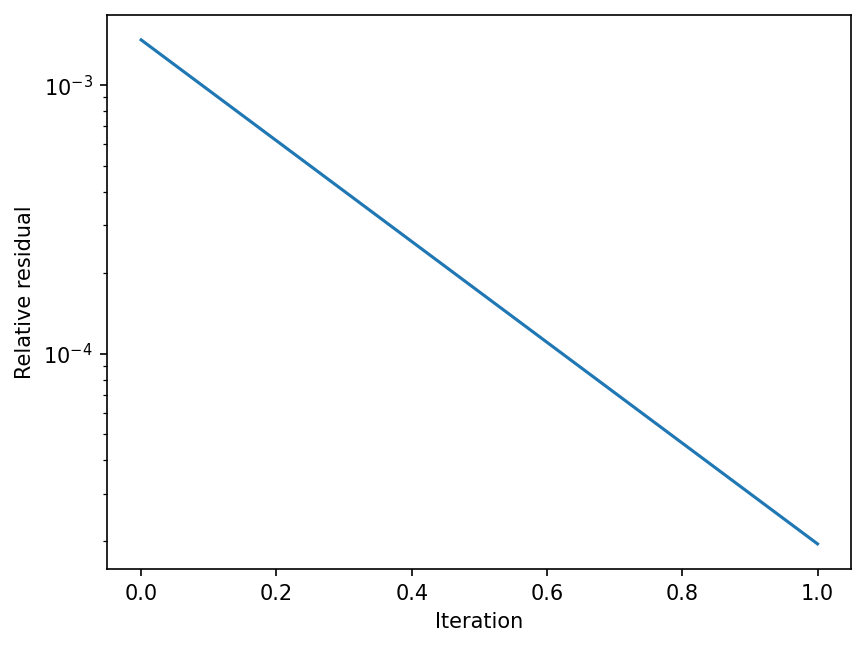

In [4]:
# parameters for FODE
alpha = 0.8
T = 1
Nt = 20
d = 2
n_samples = 3

u0 = torch.randn(n_samples,d)
uT = u0.clone().unsqueeze(-1).expand(-1,-1,Nt)

net = FODE(alpha,T,Nt,d)

def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

Z, res = forward_iteration(lambda Z : net(Z,u0), uT, tol=1e-4)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

Now, we implement the layer that has as an input $u(0)$, generates a trivial $\mathbf{U}_0$ first guess and iterates until $\mathbf{U}^*$ is reached, all this while specifying the computational graph how to compute gradients for this forward pass with our custom rule (without storing in the computational graph all the fixed point iterations).

In [5]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x),
                                              torch.zeros_like(x).unsqueeze(-1).repeat(1,1,self.f.Nt),
                                              **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z


Validating that the gradient we defined actually works. I actually don't know what is this but I trust the authors of the DEQ workshop so it should be important.

In [6]:
from torch.autograd import gradcheck
deq = DEQFixedPoint(net.double(), forward_iteration, tol=1e-10, max_iter=500)
gradcheck(deq, u0.double().requires_grad_(), eps=1e-5, atol=1e-3, check_undefined_grad=False)

True

## Experiments
Now, let's train a realistic example. I have no GPU so I'm sorry! This is all we get, so with this low amount of samples, we should not expect amazing results. I will try to show a funny trajectory at least.

In [7]:
n_samples = 1000
d = 5
T = 20
Nt = 20
alpha = 0.9

u0_ex = torch.randn(n_samples, d)*3
hidden_net = FODE(alpha,T,Nt,d)
hidden_deq = DEQFixedPoint(hidden_net,forward_iteration)
uT_ex = hidden_deq(u0_ex).detach()

dataset = TensorDataset(u0_ex,uT_ex)
trainable_net = FODE(alpha,T,Nt,d)
model = DEQFixedPoint(trainable_net,forward_iteration)

train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size   
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # I don't have gpu I'm poor
def epoch(loader, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.MSELoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
                
        total_loss += loss.item() * X.shape[0]

    return total_loss / len(loader.dataset)

If you are reading this, I also wonder why the validation loss is smaller when you start.

# Parameters:  410
Epoch 1/50 - Training Loss: 5.4511
Epoch 1/50 - Validation Loss: 2.0516
Epoch 11/50 - Training Loss: 0.3500
Epoch 11/50 - Validation Loss: 0.3286
Epoch 21/50 - Training Loss: 0.2007
Epoch 21/50 - Validation Loss: 0.2004
Epoch 31/50 - Training Loss: 0.1415
Epoch 31/50 - Validation Loss: 0.1464
Epoch 41/50 - Training Loss: 0.1249
Epoch 41/50 - Validation Loss: 0.1332


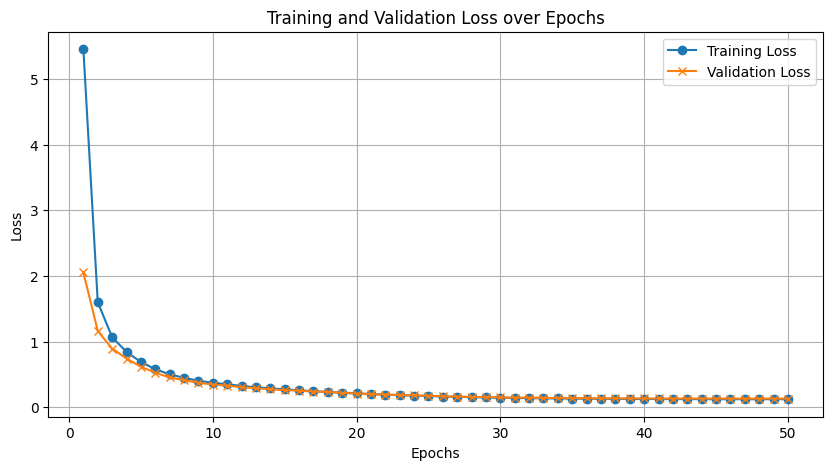

In [9]:
opt = optim.Adam(model.parameters(), lr=1e-3)
max_epochs = 50

scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs * len(train_loader), eta_min=1e-6)

# Print the number of parameters in the model
print("# Parameters: ", sum(p.numel() for p in model.parameters()))

# Hyperparameters
train_losses = []
val_losses = []


# Training and validation loop
for epoch_index in range(max_epochs):
    # Train the model
    train_loss = epoch(train_loader, model, opt, scheduler)
    train_losses.append(train_loss)
    
    # Validate the model
    val_loss = epoch(val_loader, model)
    val_losses.append(val_loss)
    if epoch_index % 10 == 0:
        print(f'Epoch {epoch_index+1}/{max_epochs} - Training Loss: {train_loss:.4f}')
        print(f'Epoch {epoch_index+1}/{max_epochs} - Validation Loss: {val_loss:.4f}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, max_epochs + 1), val_losses, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [13]:
def plot2d(u0, uT_pred, uT_true):
    plt.figure(figsize=(19.2, 10.8), dpi=100)
    # Scatter plot for initial condition
    plt.scatter(u0[0], u0[1], color='green', s=100, edgecolor='black', label='Initial Condition')

    # Scatter plot for predicted values
    plt.scatter(uT_pred[0, :], uT_pred[1, :], color='blue', alpha=0.6, label='Predicted')

    # Scatter plot for true values
    plt.scatter(uT_true[0, :], uT_true[1, :], color='red', alpha=0.6, label='True')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('2D Trajectory Comparison: Initial Condition, Predicted vs True')
    plt.legend()
    plt.grid(True)
    plt.show()

Now let's see a fairly nice trayectory which was learned pretty decently.

In [21]:
val_dataset[0][0]

tensor([ 1.1926, -0.4729,  0.8906, -0.6275,  5.8455])

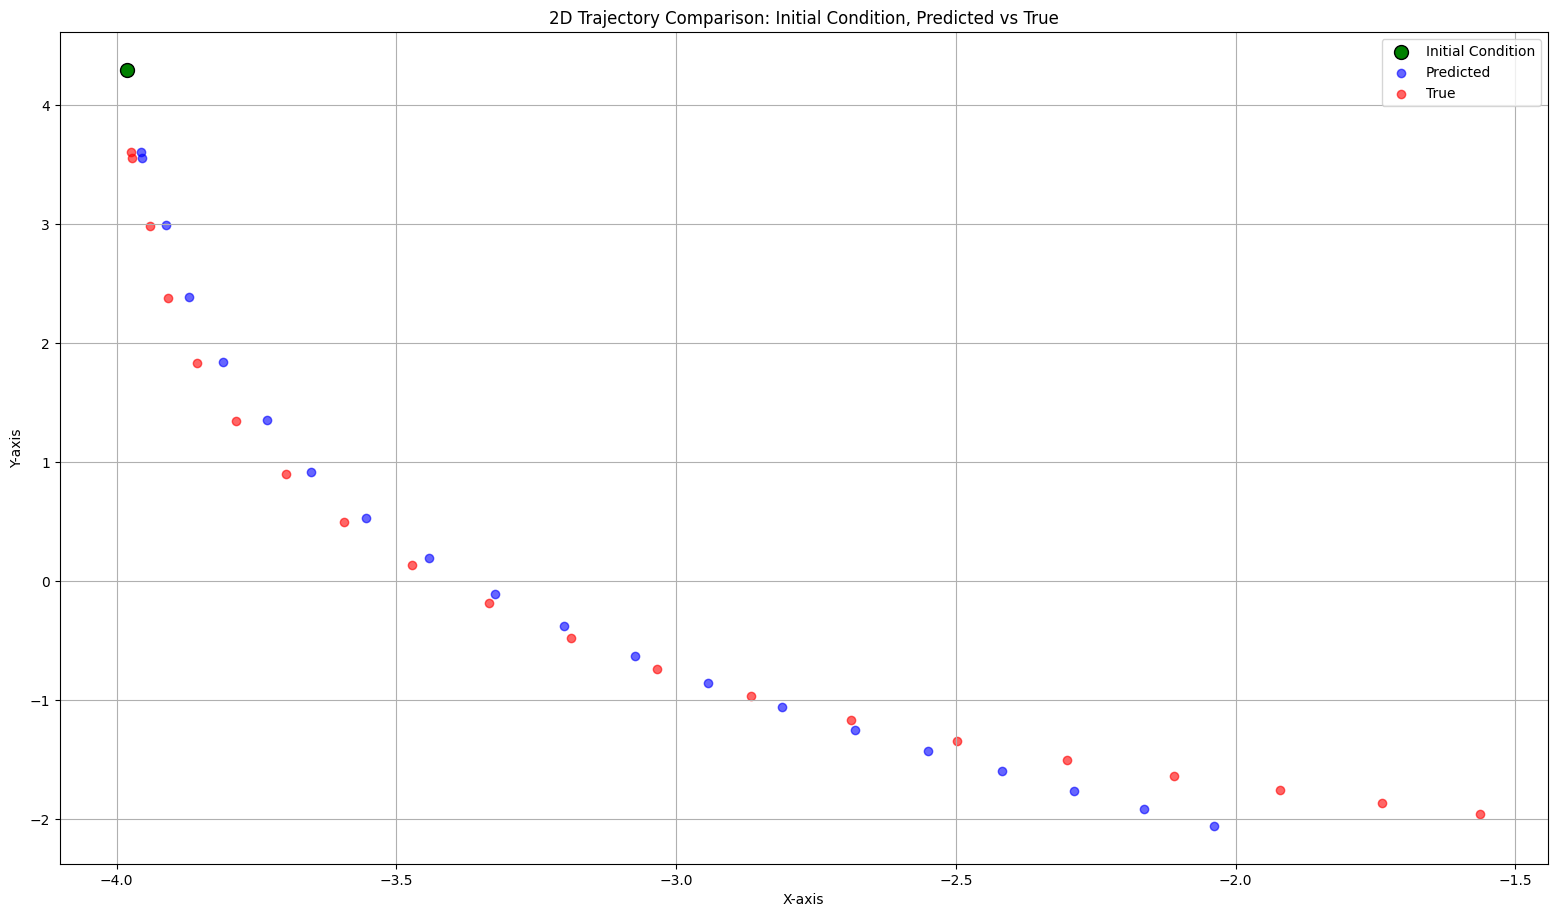

In [37]:
i = 16
pred = model(val_dataset[i][0]).squeeze(0).detach().numpy()
true = val_dataset[i][1].numpy()
plot2d(val_dataset[i][0],pred,true)

And one that was not learned well overall.

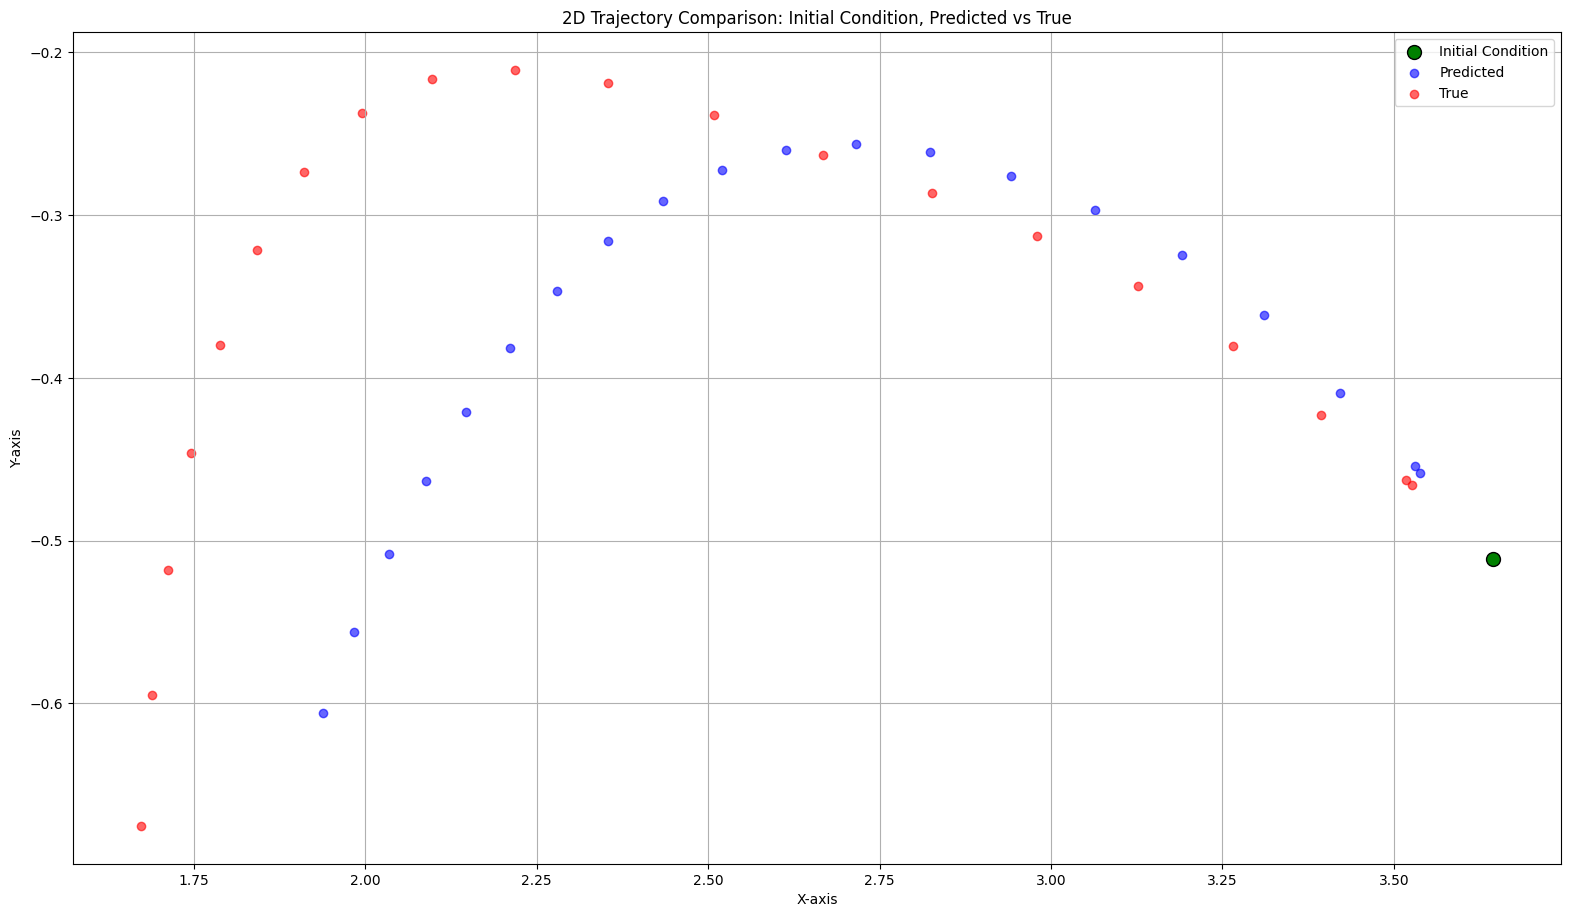

In [38]:
i = 21
pred = model(val_dataset[i][0]).squeeze(0).detach().numpy()
true = val_dataset[i][1].numpy()
plot2d(val_dataset[i][0],pred,true)

Please do not be disencouraged! I had only $100$ samples, that is virtually nothing for deep learning standards.